In [13]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as  plt
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
tf.random.set_seed(3)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from collections import Counter

In [14]:
!pip install kaggle

In [15]:
import kagglehub
import os

# Download the dataset
dataset_path = kagglehub.dataset_download("ismailnasri20/driver-drowsiness-dataset-ddd")
print("Path to dataset files:", dataset_path)

# Count the number of files in the directory
file_count = sum(len(files) for _, _, files in os.walk(dataset_path))
print("Number of files in the directory:", file_count)

Path to dataset files: /kaggle/input/driver-drowsiness-dataset-ddd
Number of files in the directory: 41793


In [16]:
!pip install split-folders

In [17]:
for root, dirs, files in os.walk(dataset_path):
    print("Directory:", root)
    print("Contains directories:", dirs)
    print("Contains files:", files)

Directory: /kaggle/input/driver-drowsiness-dataset-ddd
Contains directories: ['Driver Drowsiness Dataset (DDD)']
Contains files: []
Directory: /kaggle/input/driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DDD)
Contains directories: ['Non Drowsy', 'Drowsy']
Contains files: []
Directory: /kaggle/input/driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DDD)/Non Drowsy
Contains directories: []
Contains files: ['e0604.png', 'y0868.png', 'a1012.png', 'c0445.png', 'u0030.png', 'r0229.png', 'n0503.png', 'za0739.png', 'm0348.png', 'zc0313.png', 'za0968.png', 'c0143.png', 'e1034.png', 'zb0666.png', 'r0004.png', 'j0663.png', 'zb0857.png', 'r0278.png', 'zb0147.png', 'e0474.png', 'y0282.png', 'zb0906.png', 'x0867.png', 'x0214.png', 'd0559.png', 'y1016.png', 'h0456.png', 'b0279.png', 'zc0207.png', 'k0146.png', 'u0397.png', 'x1218.png', 'g0077.png', 'a0388.png', 'za0112.png', 'zc0710.png', 'c0021.png', 'n0983.png', 'y0960.png', 'l0347.png', 'm0308.png', 'zc0937.png', 'r0244.png', 'za03

In [18]:
import splitfolders
import os

# Path to the subdirectory containing 'Drowsy' and 'Non Drowsy'
actual_dataset_path = os.path.join(
    dataset_path,
    "Driver Drowsiness Dataset (DDD)"
)

# Verify that the path contains subdirectories
print("Contents of the dataset directory:")
print(os.listdir(actual_dataset_path))

# Split the dataset
output_dir = 'splitted_dataset'
splitfolders.ratio(actual_dataset_path, output=output_dir, seed=1337, ratio=(.8, 0.15, 0.05))

Contents of the dataset directory:
['Non Drowsy', 'Drowsy']


Copying files: 41793 files [00:46, 906.55 files/s]


In [24]:
train_dir = "splitted_dataset/train"
test_dir = "splitted_dataset/test"
val_dir = "splitted_dataset/val"

In [20]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

In [21]:
train_batches = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary',
    shuffle=True
)

Found 33434 images belonging to 2 classes.


In [26]:
test_batches = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary' ,
    shuffle=True
)

Found 2091 images belonging to 2 classes.


In [27]:
val_batches = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary',
    shuffle=True
)

Found 6268 images belonging to 2 classes.


In [28]:
train_class_indices = train_batches.class_indices
test_class_indices = test_batches.class_indices
val_class_indices = val_batches.class_indices

train_class_labels = train_batches.classes
test_class_labels = test_batches.classes
val_class_labels = val_batches.classes

train_class_counts = Counter(train_class_labels)
test_class_counts = Counter(test_class_labels)
val_class_counts = Counter(val_class_labels)

print("Class Names for train:\n", train_class_indices)
print("Class Counts for train:\n", train_class_counts)
print(end='\n')

print("Class Names for test:\n", test_class_indices)
print("Class Counts for test:\n", test_class_counts)
print(end='\n')

print("Class Names for validation :\n", val_class_indices)
print("Class Counts for validation:\n", val_class_counts)

Class Names for train:
 {'Drowsy': 0, 'Non Drowsy': 1}
Class Counts for train:
 Counter({np.int32(0): 17878, np.int32(1): 15556})

Class Names for test:
 {'Drowsy': 0, 'Non Drowsy': 1}
Class Counts for test:
 Counter({np.int32(0): 1118, np.int32(1): 973})

Class Names for validation :
 {'Drowsy': 0, 'Non Drowsy': 1}
Class Counts for validation:
 Counter({np.int32(0): 3352, np.int32(1): 2916})


Pixels of the first image after Normalization: 

[[[0.7019608  0.69803923 0.6745098 ]
  [0.69411767 0.6901961  0.6666667 ]
  [0.6862745  0.6745098  0.6431373 ]
  ...
  [0.67058825 0.6509804  0.6039216 ]
  [0.6745098  0.654902   0.6117647 ]
  [0.6784314  0.65882355 0.6156863 ]]

 [[0.69411767 0.6901961  0.6666667 ]
  [0.6862745  0.6862745  0.6627451 ]
  [0.6901961  0.6784314  0.6509804 ]
  ...
  [0.6784314  0.6509804  0.60784316]
  [0.6784314  0.6509804  0.60784316]
  [0.6784314  0.65882355 0.6156863 ]]

 [[0.6862745  0.68235296 0.654902  ]
  [0.6862745  0.68235296 0.6509804 ]
  [0.6901961  0.6784314  0.64705884]
  ...
  [0.6784314  0.6509804  0.60784316]
  [0.6784314  0.6509804  0.60784316]
  [0.68235296 0.65882355 0.60784316]]

 ...

 [[0.5058824  0.48235297 0.4039216 ]
  [0.49803925 0.47450984 0.3921569 ]
  [0.49803925 0.47450984 0.427451  ]
  ...
  [0.78823537 0.77647066 0.77647066]
  [0.4156863  0.3803922  0.39607847]
  [0.3254902  0.28235295 0.3372549 ]]

 [[0.5058824  0.49411768 

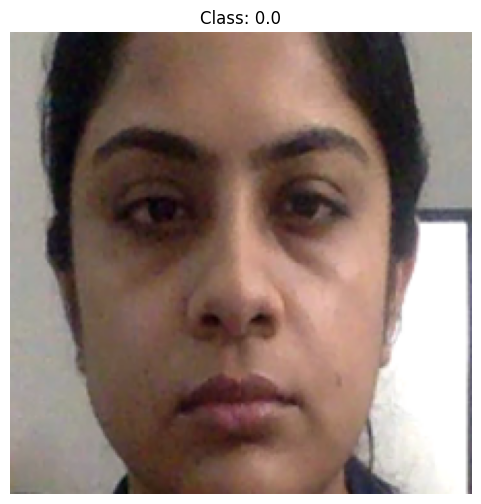

In [29]:
import matplotlib.pyplot as plt

# Retrieve a batch of images and labels from the training set
images, labels = next(train_batches)

# Print the pixel values of the first image after normalization
# Normalization should have scaled the pixel values to a range of [0, 1]
print(f"Pixels of the first image after Normalization: \n\n{images[0]}")

# Plot the first image to visually inspect the preprocessing
plt.figure(figsize=(6,6))  # Set the figure size for better visualization
plt.imshow(images[0])  # Display the first image in the batch
plt.axis('off')  # Remove axis labels for a cleaner display
plt.title(f"Class: {labels[0]}")  # Show the class label (Drowsy or Non-Drowsy) on the plot
plt.show()

In [30]:
print(f"there are { images[0].ndim} Channels ")
print(f"image shape : {images[0].shape}")

there are 3 Channels 
image shape : (224, 224, 3)


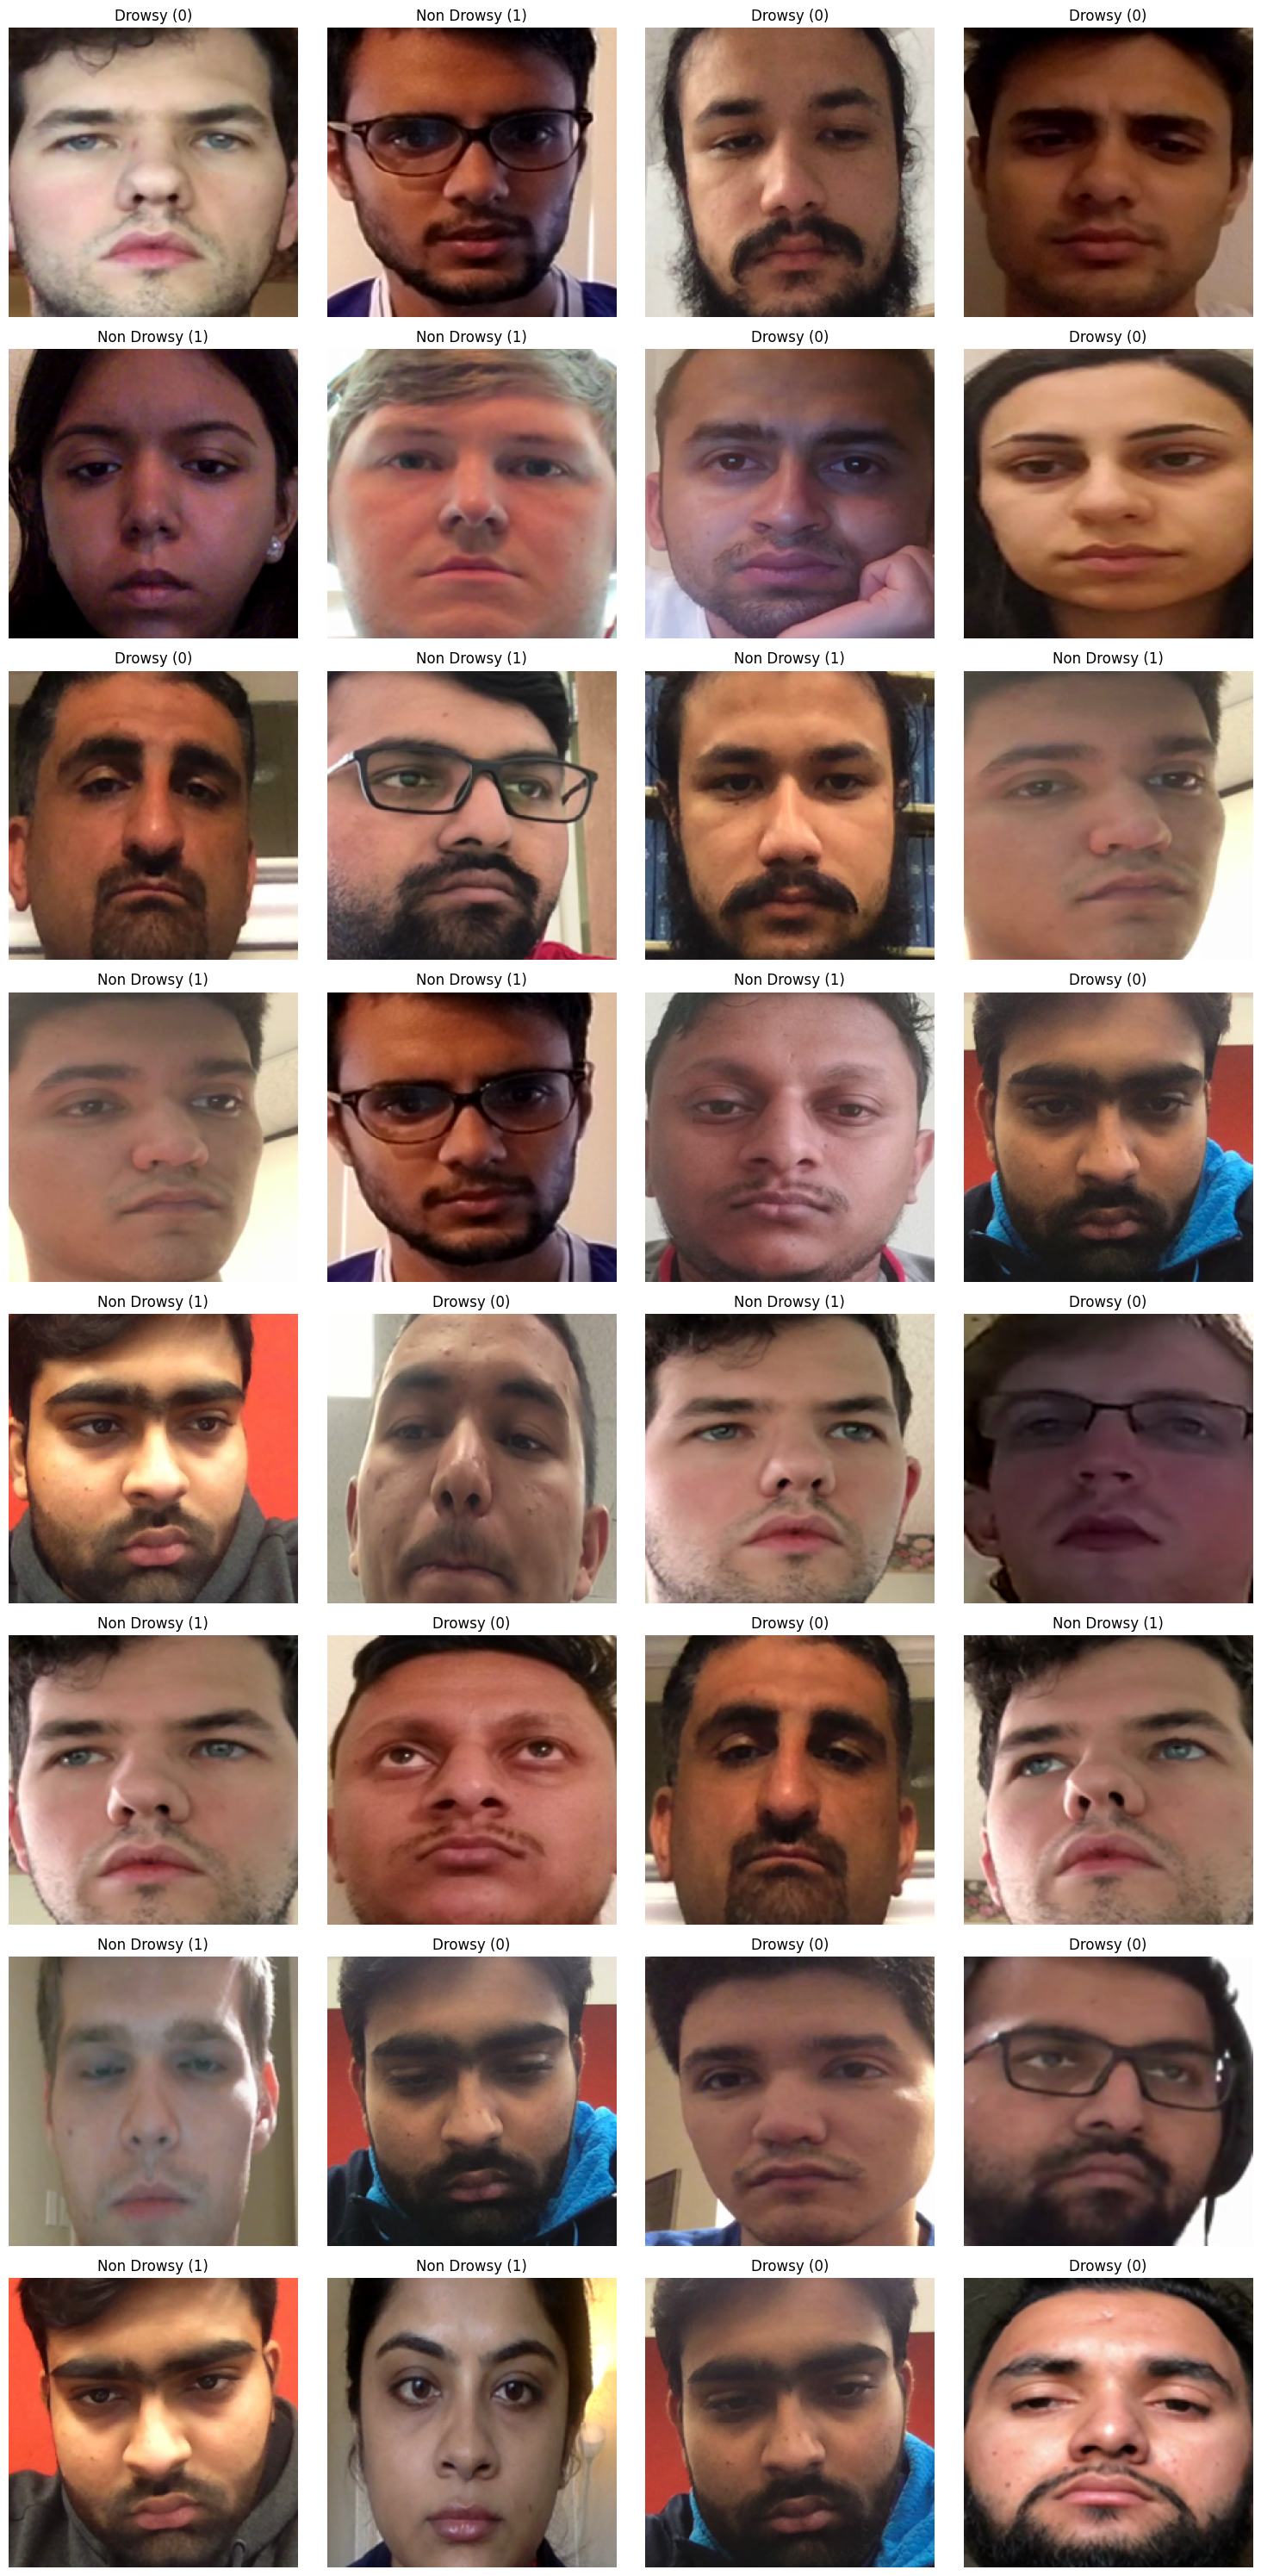

In [31]:
import matplotlib.pyplot as plt

# Create a grid of 8 rows and 4 columns for displaying images
fig, axes = plt.subplots(8, 4, figsize=(15, 30))

# Get class indices to map labels to their corresponding class names
class_indices = train_batches.class_indices

# Loop through the 8 rows and 4 columns to display 32 images
for i in range(8):
    images, labels = next(train_batches)

    for j in range(4):
        ax = axes[i, j]

        # Display the image
        ax.imshow(images[j])

        # Hide the axes for better clarity
        ax.axis('off')

        # Get the label for the image and map it to the class name
        label = int(labels[j])
        label_name = list(class_indices.keys())[list(class_indices.values()).index(label)]

        # Set the title with the class name and label
        ax.set_title(f'{label_name} ({label})', fontsize=12)

# Adjust the layout to prevent overlapping titles
plt.tight_layout()

# Show the plot
plt.show()

In [32]:
# Define the image size
image_size = (224, 224)

# Initialize the MobileNetV2 model with the defined input shape
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(image_size[0], image_size[1], 3),
)

# Check the type of the base model
print(type(base_model))

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
<class 'keras.src.models.functional.Functional'>


In [33]:
# Get the summary of model
base_model.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [34]:
# Initializing a Sequential model
model = keras.Sequential()

# Freezing the layers of the base model (except the last 25 layers)
# This prevents their weights from being updated during training
for layer in base_model.layers[:-25]:
    layer.trainable = False

# Adding a Flatten layer to transform the 2D outputs of the base model into a 1D vector
x = base_model.output
x = Flatten()(x)

# Adding fully connected Dense layers to the model
# The first Dense layer has 1024 units and uses ReLU activation for non-linearity
x = Dense(1024, activation='relu')(x)

# The second Dense layer has 512 units, again with ReLU activation
x = Dense(512, activation='relu')(x)

# The output layer with 2 units for the binary classification (Drowsy vs. Non-Drowsy)
# We use the softmax activation function to output probabilities for each class
predictions = Dense(2, activation='softmax')(x)

# Creating the final model, where the input is the base model input and output is the predictions
model = Model(inputs=base_model.input, outputs=predictions)

# Summarizing the model architecture to inspect the layers and parameters
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 67,010,114 (255.62 MB)

 Trainable params: 66,114,050 (252.21 MB)

 Non-trainable params: 896,064 (3.42 MB)

In [35]:
# Compiling the model
model.compile(
    optimizer=Adam(0.0001),  # Adam optimizer with a learning rate of 0.0001
    loss='sparse_categorical_crossentropy',  # Loss function for multi-class classification
    metrics=['accuracy']  # Metric to track during training
)

In [37]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # or 'val_accuracy'
    patience=3,  # Number of epochs to wait for improvement
    restore_best_weights=True  # Restore the best weights when training is stopped
)

# Train the model with EarlyStopping
history = model.fit(
    train_batches,
    epochs=20,
    validation_data=val_batches,
    batch_size=512,
    callbacks=[early_stopping]
)

Epoch 1/20
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 157s 75ms/step - accuracy: 0.9985 - loss: 0.0102 - val_accuracy: 0.9992 - val_loss: 0.0024
Epoch 2/20
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 163s 78ms/step - accuracy: 0.9992 - loss: 0.0069 - val_accuracy: 0.9997 - val_loss: 0.0025
Epoch 3/20
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 156s 75ms/step - accuracy: 0.9997 - loss: 0.0014 - val_accuracy: 0.9987 - val_loss: 0.0113
Epoch 4/20
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 160s 76ms/step - accuracy: 0.9999 - loss: 7.7238e-04 - val_accuracy: 0.9995 - val_loss: 0.0026


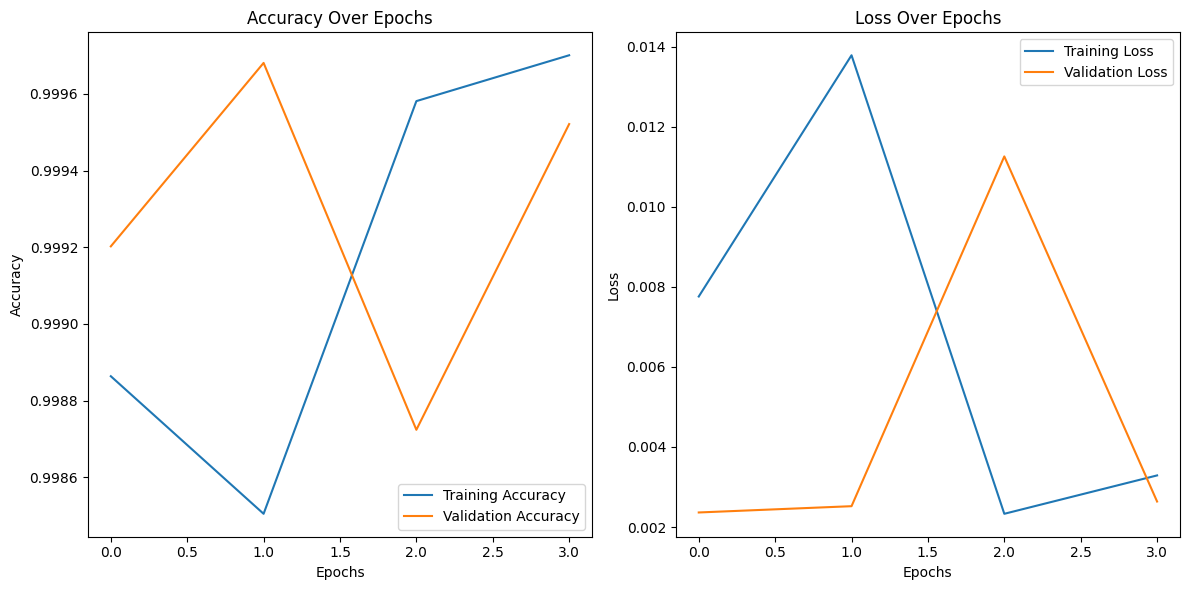

In [38]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [39]:
# Ensure the directory exists
save_dir = "saved_model"
os.makedirs(save_dir, exist_ok=True)

# Define save paths
model_path = os.path.join(save_dir, "model.keras")
weights_path = os.path.join(save_dir, "model.weights.h5")

# Save the full model
model.save(model_path)

# Save only the weights
model.save_weights(weights_path)

print(f"Model saved successfully at {model_path}")

Model saved successfully at saved_model/model.keras


In [40]:
# Convert the saved model to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model
tflite_model_path = "saved_model/model.tflite"
with open(tflite_model_path, "wb") as f:
    f.write(tflite_model)

print(f"Model saved at {tflite_model_path}")

Saved artifact at '/tmp/tmpep5ues8a'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  135430712995536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135430712986896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135430712998800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135430712998416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135430712997264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135430712998992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135430712998032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135430712999568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135430712999184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135430712995728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13543071299822

Image: W0016.png - Predicted: Drowsy (100.00%) - Actual: Drowsy → ✅ Correct
Image: S0146.png - Predicted: Drowsy (100.00%) - Actual: Drowsy → ✅ Correct
Image: Y0490.png - Predicted: Drowsy (100.00%) - Actual: Drowsy → ✅ Correct
Image: ZA0217.png - Predicted: Drowsy (100.00%) - Actual: Drowsy → ✅ Correct
Image: X0107.png - Predicted: Drowsy (100.00%) - Actual: Drowsy → ✅ Correct
Image: T0609.png - Predicted: Drowsy (100.00%) - Actual: Drowsy → ✅ Correct
Image: O0924.png - Predicted: Drowsy (100.00%) - Actual: Drowsy → ✅ Correct
Image: K0172.png - Predicted: Drowsy (100.00%) - Actual: Drowsy → ✅ Correct
Image: L0294.png - Predicted: Drowsy (100.00%) - Actual: Drowsy → ✅ Correct
Image: I0532.png - Predicted: Drowsy (100.00%) - Actual: Drowsy → ✅ Correct
Image: W0333.png - Predicted: Drowsy (100.00%) - Actual: Drowsy → ✅ Correct
Image: C0126.png - Predicted: Drowsy (100.00%) - Actual: Drowsy → ✅ Correct
Image: N0708.png - Predicted: Drowsy (100.00%) - Actual: Drowsy → ✅ Correct
Image: ZB07

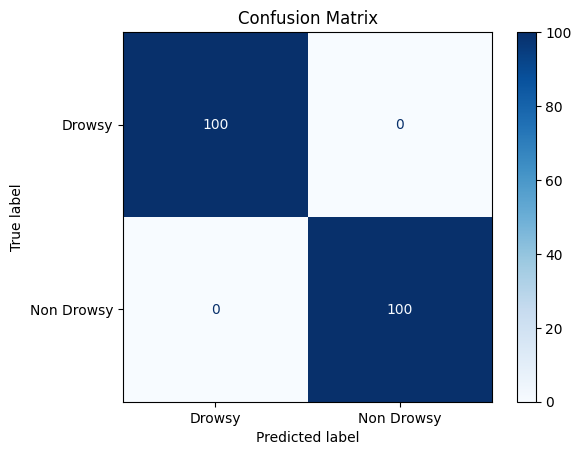

In [48]:
import os
import random
import time
import numpy as np
from PIL import Image
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Define paths
valid_images_path = "splitted_dataset/test"
subfolders = ["Drowsy", "Non Drowsy"]  # Class labels

# Sample size per category
sample_size = 100

# Collect a sample of image paths
image_paths, true_labels = [], []
for subfolder in subfolders:
    folder_path = os.path.join(valid_images_path, subfolder)
    all_images = [img for img in os.listdir(folder_path) if img.endswith(('.jpg', '.png'))]

    # Randomly select images
    sampled_images = random.sample(all_images, min(sample_size, len(all_images)))

    for img in sampled_images:
        image_paths.append(os.path.join(folder_path, img))
        true_labels.append(subfolders.index(subfolder))  # Store as index for sklearn

# Load model
model = tf.keras.models.load_model("saved_model/model.keras")

# Function to preprocess image
def preprocess_image(image_path):
    img = Image.open(image_path).resize((224, 224))
    img = np.array(img) / 255.0
    img = np.expand_dims(img, axis=0)
    return img

# Evaluate model
correct_predictions = 0
total_images = len(image_paths)
inference_times = []
predicted_labels = []

for image_path, true_label in zip(image_paths, true_labels):
    img = preprocess_image(image_path)

    # Measure inference time
    start_time = time.time()
    predictions = model.predict(img, verbose=0)
    end_time = time.time()

    inference_time = end_time - start_time
    inference_times.append(inference_time)

    # Get predicted class
    predicted_class_index = np.argmax(predictions)
    predicted_labels.append(predicted_class_index)

    is_correct = predicted_class_index == true_label
    correct_predictions += int(is_correct)

    print(f"Image: {os.path.basename(image_path)} - Predicted: {subfolders[predicted_class_index]} ({np.max(predictions)*100:.2f}%) - Actual: {subfolders[true_label]} → {'✅ Correct' if is_correct else '❌ Incorrect'}")

# Final metrics
accuracy = (correct_predictions / total_images) * 100 if total_images > 0 else 0
avg_inference_time = np.mean(inference_times) if inference_times else 0

print(f"\nFinal Score: {correct_predictions}/{total_images} correct ({accuracy:.2f}% accuracy)")
print(f"Average Inference Time per Image: {avg_inference_time:.4f} seconds ({1/avg_inference_time:.2f} FPS)")

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=subfolders)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()


In [42]:
import shutil

# Replace with your folder path
folder_path = "saved_model"

# Output zip file path
zip_path = "saved_model.zip"

# Create the zip file
shutil.make_archive(zip_path.replace(".zip", ""), 'zip', folder_path)


'/content/saved_model.zip'

In [44]:
from google.colab import files

# Trigger download
files.download(zip_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [43]:
import zipfile
import os

# Specify the path to your zip file and the extraction directory
zip_file_path = "archive.zip"  # Replace with the actual path to your zip file
extraction_dir = "archive"   # Replace with the desired extraction directory

# Create the extraction directory if it doesn't exist
os.makedirs(extraction_dir, exist_ok=True)

try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extraction_dir)
    print(f"Successfully extracted {zip_file_path} to {extraction_dir}")
except FileNotFoundError:
    print(f"Error: Zip file not found at {zip_file_path}")
except Exception as e:
    print(f"An error occurred during extraction: {e}")

Successfully extracted archive.zip to archive
